## 1) Model evaluation

Description: (a) Examine tuned LDA model topics for interpretability
             (b) For given test cases, plot the distribution of topics for that movie
             (c) For given test cases, find top N movies with the most similar topic distributions

In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
import time
import gradio as gr
import pickle

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

c:\Users\Nick\.conda\envs\recsys_movie\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load in tuned model and transformed document-topic matrix
lda_main = pickle.load(open('model_building\\model_2023_08_16.sav', 'rb'))
lda10 = pickle.load(open('model_building\\hyperparameter_tuning\\model_10_components.sav', 'rb'))
lda20 = pickle.load(open('model_building\\hyperparameter_tuning\\model_20_components.sav', 'rb'))

with open("data_preprocessing_eda_out\\word_key.txt", "rb") as f:
    word_key = pickle.load(f)

# read in movie database
df = pd.read_csv("data_preprocessing_eda_out\\df_spaces_upload.csv", index_col=[0])

# read in scipy sparse matrix
X = sparse.load_npz("data_preprocessing_eda_out\\X.npz")
with open("model_building\\Xtran.txt", "rb") as f:
    Xtran_main = pickle.load(f)

Xtran10 = lda10.transform(X)
Xtran20 = lda20.transform(X)

n_movies = len(df)
n_features = len(word_key)

In [ ]:
def plot_top_words(model, feature_names, n_top_words, n_components, title):
    # output: plot of top n_top_words for each topic in the model
    fig, axes = plt.subplots(
        int(np.ceil(n_components / 5)),
        5,
        figsize=(30, 30 * n_components / 20),
        sharex=True,
    )
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda_main, word_key, n_top_words=20, n_components=20, title="Topics in LDA model")
# plot_top_words(lda20, word_key, n_top_words=20, n_components=20, title="Topics in LDA model")

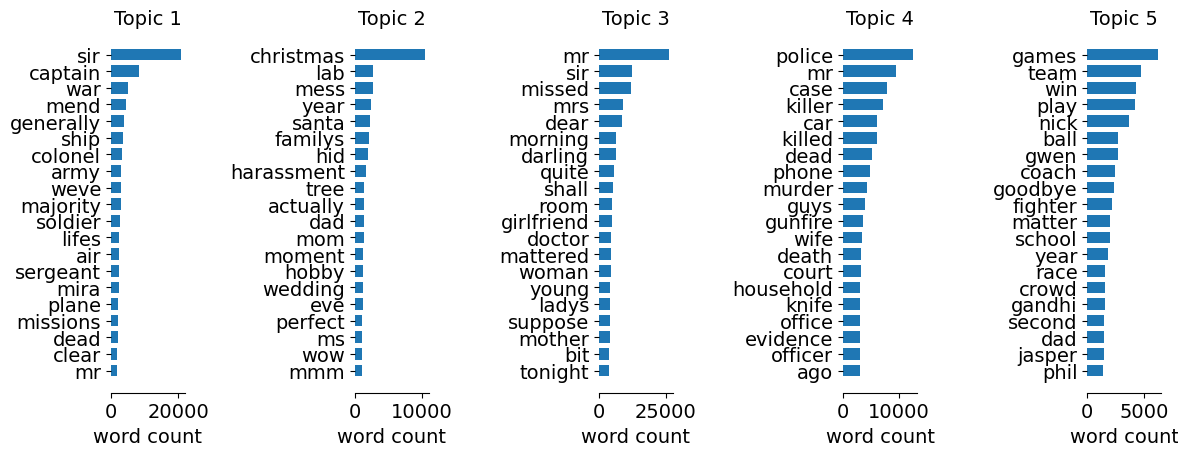

In [13]:
def plot_top_words_selected_topics(
    model, feature_names, n_top_words, n_components, title, select_topics
):
    # output: plot of top n_top_words for each topic in the model
    fig, axes = plt.subplots(
        1,
        5,
        figsize=(12, 5),
        sharex=False,
    )
    axes = axes.flatten()
    kk = -1
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx in select_topics:
            kk = kk + 1
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[kk]
            ax.barh(top_features, weights, height=0.7)
            ax.set_title(f"Topic {kk+1}", fontdict={"fontsize": 14})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=14)
            ax.set_xlabel("word count", fontdict={"fontsize": 14})
            for i in "top right left".split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=18)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.tight_layout()
    
    return fig

plt.rcParams.update({'font.size': 14})
fig = plot_top_words_selected_topics(
    lda_main, word_key, 20, 20, "", [0, 1, 2, 3, 5]
)
fig.tight_layout()
# fig.figure.savefig('model_eval\\select_topics.png', dpi=450, bbox_inches="tight")

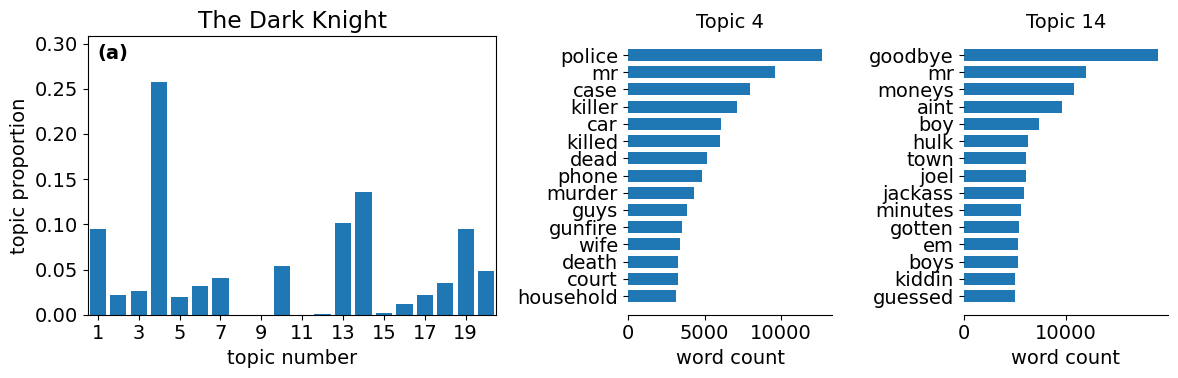

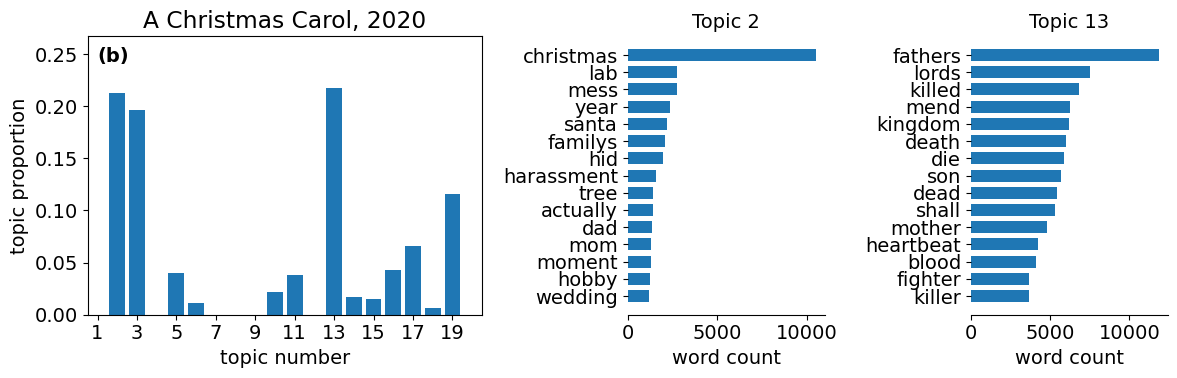

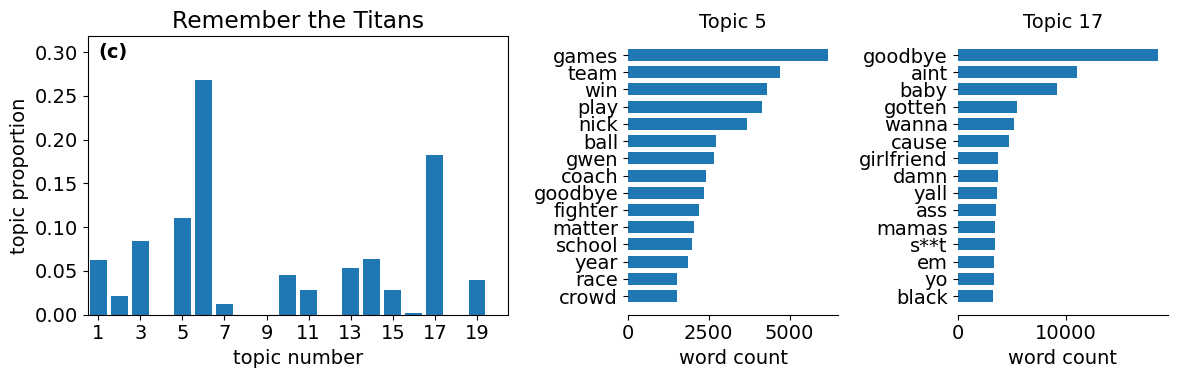

In [29]:
# define some test cases - will be used as examples in app
n_components = 20

plt.rcParams.update({"font.size": 14})
tested_examples = [
    ["The Dark Knight", "7.1", True],
    ["A Christmas Carol, 2020", "7.1", True],
    ["Remember the Titans", "7.1", True],
]

# visualize the topic distribution for tested_examples

# plot distribution of topic weights

label_str = ["(a)", "(b)", "(c)"]
top_title = [4, 14, 2, 13, 5, 17]
for j, ex in enumerate(tested_examples):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4), width_ratios=[2, 1, 1])
    ax = ax.flatten()
    jmovie = df[df["movie_title"] == ex[0]].index[0]
    prob_height = np.round(Xtran_main[jmovie, :].reshape(1, n_components), 3).reshape(-1)
    arg_topic = np.flip(np.argsort(prob_height))
    ax[0].bar(x=list(range(1, n_components + 1)), height=prob_height)
    ax[0].set_ylim(0, np.max(prob_height) + 0.05)
    ax[0].set_xlim(0.5, n_components + 0.5)
    ax[0].set_ylabel("topic proportion")
    ax[0].set_xlabel("topic number")
    ax[0].set_title(ex[0])
    ax[0].set_xticks(list(range(1, n_components + 1, 2)))
    ax[0].text(1, np.max(prob_height) + 0.025, label_str[j], fontweight='bold')

    kk = 0
    for topic_idx, topic in enumerate(lda_main.components_):
        if topic_idx in arg_topic[0:2]:
            kk = kk + 1
            top_features_ind = topic.argsort()[: -15 - 1 : -1]
            top_features = [word_key[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax[kk].barh(top_features, weights, height=0.7)
            ax[kk].set_title(f"Topic {top_title[kk-1 + j*2]}", fontdict={"fontsize": 14})
            ax[kk].invert_yaxis()
            ax[kk].tick_params(axis="both", which="major", labelsize=14)
            ax[kk].set_xlabel("word count", fontdict={"fontsize": 14})

            for i in "top right left".split():
                ax[kk].spines[i].set_visible(False)

    fig.tight_layout()
    fig.figure.savefig(
        "model_eval\\"
        + ex[0].replace(" ", "_").replace("-", "").replace("'", "").lower()
        + "_top_topics.png",
        dpi=450,
        bbox_inches="tight",
    )

# 2) Model prediction and ranking of recommendations

In [99]:
def movie_rec(movie_name, rating_min, is_adult, Xtran, num_rec=5):
    # compute top 5 movie recommendations for the input movie and filters
    # inputs:
    #       movie_name: selected movie_name from radio
    #       rating_min: filter out all movies with ratings less than rating_min
    #       is_adult: if True then filter out adult titles
    # ouputs:
    #       df_in: dataframe with all the info on movie_name
    #       df_out: dataframe with all the info on top 5 recommended movies

    if not movie_name:
        raise gr.Error("Please select a movie before clicking Recommend")

    jmovie = df[df["movie_title"] == movie_name].index[0]
    sim_in = Xtran[jmovie, :].reshape(1, Xtran.shape[1])

    if "NULL" in df["imdb_link"].iloc[jmovie]:
        # input movie has no matching IMDb title
        link_in = ["N/A"]
        genre_in = ["N/A"]
        rating_in = ["N/A"]
    else:
        # link_in = construct_markdown_link([df["imdb_link"].iloc[jmovie]], [movie_name])
        genre_in = [df["genre"].iloc[jmovie]]
        rating_in = [df["average_rating"].iloc[jmovie]]

    # construct input dataframe
    df_in = pd.DataFrame(
        {
            "Title": [movie_name],
            "Year": [df["movie_year"].iloc[jmovie]],
            "IMDb Rating": rating_in,
            "Genres": genre_in,
            # "IMDb Link": link_in,
        }
    )

    # compute similarity between movie_name and all other movies in database
    sim_movie = cosine_similarity(sim_in, Xtran).reshape((len(df),))

    # sort dataframe by movie similarity in descending order
    arg_sim_movie_ordered = np.flip(np.argsort(sim_movie))
    df_sort = df.iloc[arg_sim_movie_ordered[1:]]

    # fiter by rating_min and is_adult
    df_sort = df_sort[df_sort["average_rating"] >= float(rating_min)]
    if is_adult:
        df_sort = df_sort[df_sort["is_adult"] == 0]

    # raise error if less than num_Rec movies are left after filtering
    if len(df_sort) < num_rec:
        raise gr.Error(
            "Not enough movies met the filter criteria. Try reducing the minimum rating."
        )

    # construct output dataframe
    movie_title = df_sort["movie_title"].iloc[0:num_rec].tolist()
    movie_year = df_sort["movie_year"].iloc[0:num_rec].tolist()
    rating = df_sort["average_rating"].iloc[0:num_rec].tolist()
    genre = df_sort["genre"].iloc[0:num_rec].tolist()
    # link = construct_markdown_link(df_sort["imdb_link"].iloc[0:5].tolist(), movie_title)

    df_out = pd.DataFrame(
        {
            "Title": movie_title,
            "Year": movie_year,
            "IMDb Rating": rating,
            "Genres": genre,
            # "IMDb Link": link,
        }
    )

    return df_in, df_out

In [100]:
# define some test cases - will be used as examples in app
plt.rcParams.update({"font.size": 14})
tested_examples = [
    ["Barbie", "5", True],
    ["Green Book", "6.9", True],
    ["Finding Nemo", "6", True],
    ["How to Train Your Dragon", "6.7", True],
    ["Remember the Titans", "5", True],
    ["Avengers: Endgame", "7.4", True],
]


for ex in tested_examples:
    df_in, df_out = movie_rec(ex[0], ex[1], ex[2], Xtran_main, num_rec=10)
    # df_in2, df_out2 = movie_rec(ex[0], ex[1], ex[2], Xtran20)
    print(df_in.to_markdown() + '\n')
    print(df_out.to_markdown() + '\n')
    # print(df_out2.to_markdown() + '\n')
    print('----------------------------------------------------------------------------------------\n')

|    | Title   |   Year |   IMDb Rating | Genres                   |
|---:|:--------|-------:|--------------:|:-------------------------|
|  0 | Barbie  |   2023 |           nan | Adventure,Comedy,Fantasy |

|    | Title                                         |   Year |   IMDb Rating | Genres                   |
|---:|:----------------------------------------------|-------:|--------------:|:-------------------------|
|  0 | Taylor Tomlinson: Quarter-Life Crisis         |   2020 |           7.4 | Comedy                   |
|  1 | Iliza Shlesinger: Unveiled                    |   2019 |           6.5 | Comedy                   |
|  2 | Dillo con parole mie (Ginger and Cinnamon)    |   2003 |           6.5 | Comedy,Romance           |
|  3 | 100 Girls                                     |   2000 |           5.8 | Comedy,Romance           |
|  4 | Sexy Baby                                     |   2012 |           6   | Documentary              |
|  5 | The Vagina Monologues               